This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/parameter-tuning.ipynb). It investigates tuning model parameters to achieve better performance. First we must import the necessary installed modules.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from hyperopt import hp

Next we need to import a few local modules.

In [2]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from databall.database import Database
from databall.plotting import format_538, plot_metrics, plot_matrix
from databall.model_selection import calculate_metrics, optimize_params, train_test_split
import databall.util as util

Apply the FiveThirtyEight plot style.

In [3]:
plt.style.use('fivethirtyeight')

# Data

As before, we collect the stats and betting data from the database and create training and test sets where the 2016 season is reserved as the test set.

In [4]:
database = Database('../data/nba.db')
games = database.betting_stats(window=10)
x_train, y_train, x_test, y_test = train_test_split(games, 2006, 2016,
                                                    xlabels=util.stat_names() + ['SEASON'])

The stats below are the box score stats used during [feature selection](feature-selection.md). I decided to further explore these because they are readily available from multiple sources and do not require any calculation of advanced stats by users.

In [6]:
stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK']
stats = ['TEAM_' + s for s in stats] + ['POSSESSIONS']
stats += [s + '_AWAY' for s in stats] + ['HOME_SPREAD']

# Logistic Regression

The plots below show `LogisticRegression` model performance using different combinations of three parameters in a grid search: `penalty` (type of norm), `class_weight` (where "balanced" indicates weights are inversely proportional to class frequencies and the default is one), and `dual` (flag to use the dual formulation, which changes the equation being optimized). For each combination, models were trained with different `C` values, which controls the inverse of the regularization strength.

All models have similar accuracy, ROC area, and precision/recall area for all `C` values tested. However, their individual precision and recall metrics change wildly with C. We are more interested in accuracy for this specific problem because accuracy directly controls profit. Using a grid search is not the most efficient parameter tuning method because grid searches do not use information from prior runs to aid future parameter choices. You are at the mercy of the selected grid points.

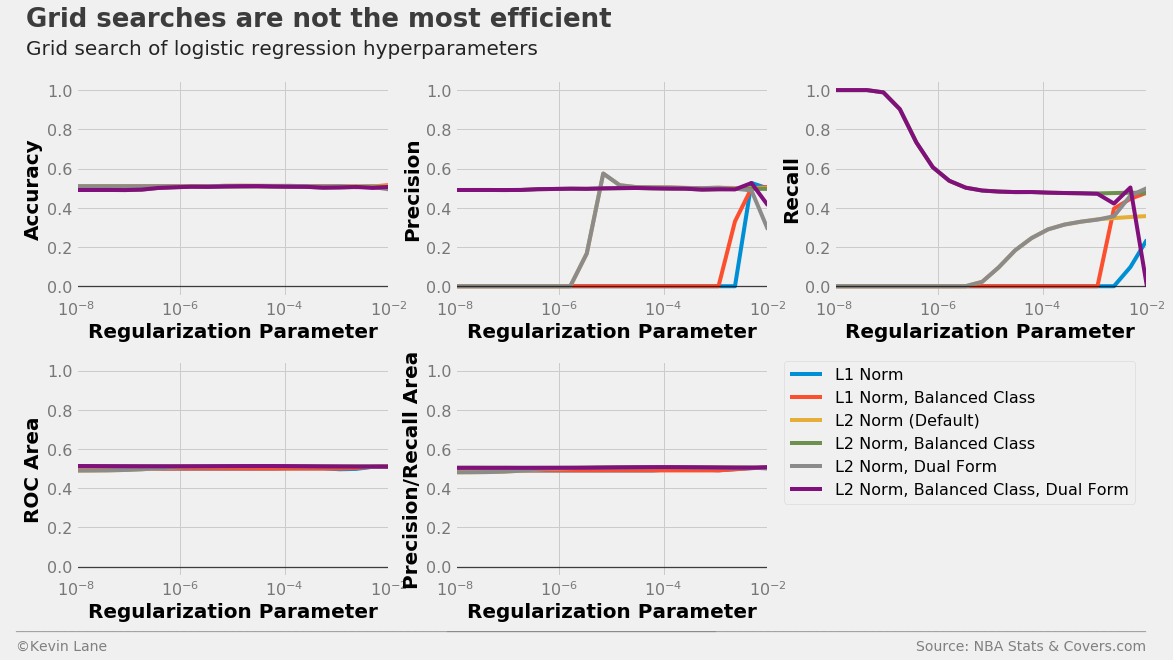

In [7]:
# Create functions that return logistic regression models with different parameters
models = [partial(LogisticRegression, penalty='l1'),
          partial(LogisticRegression, penalty='l1', class_weight='balanced'),
          partial(LogisticRegression),
          partial(LogisticRegression, class_weight='balanced'),
          partial(LogisticRegression, dual=True),
          partial(LogisticRegression, class_weight='balanced', dual=True)]

start = -8
stop = -2
C_vec = np.logspace(start=start, stop=stop, num=20)
results = calculate_metrics(models, x_train, y_train, stats, 'C', C_vec, k=6)
legend = ['L1 Norm', 'L1 Norm, Balanced Class', 'L2 Norm (Default)',
          'L2 Norm, Balanced Class', 'L2 Norm, Dual Form', 'L2 Norm, Balanced Class, Dual Form']

fig, ax = plot_metrics(C_vec, results, 'Regularization Parameter', log=True)

ax[-1].legend(legend, fontsize=16, bbox_to_anchor=(1.05, 1), borderaxespad=0)
[a.set_xlim(10**start, 10**stop) for a in ax]
[a.set_ylim(-0.05, 1.05) for a in ax]
title = 'Grid searches are not the most efficient'
subtitle = 'Grid search of logistic regression hyperparameters'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle, xoff=(-0.22, 3.45),
           yoff=(-1.54, -1.64), toff=(-.16, 1.25), soff=(-0.16, 1.12), n=100)
plt.show()

An alternative solution is to use an optimization algorithm that minimizes a loss function to select the hyperparameters. I experimented with the hyperopt package for this, which accepts a parameter search space and loss function as its inputs. The search space consists of discrete choices and ranges on continuous variables. I swapped out the `class_weight` and `dual` variables in favor of `fit_intercept` and `intercept_scaling`, which controls whether to include an intercept in the `LogisticRegression` model and a scaling factor. The scaling factor can help reduce the effect of regularization on the intercept. I chose cross-validation accuracy as the loss function (actually 1-accuracy since the optimizer minimizes the loss function) since we are interested in increasing profits. The optimal hyperparameters are displayed below.

In [8]:
space_log = {}
space_log['C'] = hp.loguniform('C', -8*np.log(10), -2*np.log(10))
space_log['intercept_scaling'] = hp.loguniform('intercept_scaling', -8*np.log(10), 8*np.log(10))
space_log['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space_log['fit_intercept'] = hp.choice('fit_intercept', [False, True])
model = LogisticRegression()
best_log, param_log = optimize_params(model, x_train, y_train, stats, space_log, max_evals=1000)
print(best_log)

{'C': 0.0001943920615336294, 'fit_intercept': True, 'intercept_scaling': 134496.71823111628, 'penalty': 'l2'}


The search history is displayed below. The intercept scale factor tended toward high values, even though the default value is 1.0.

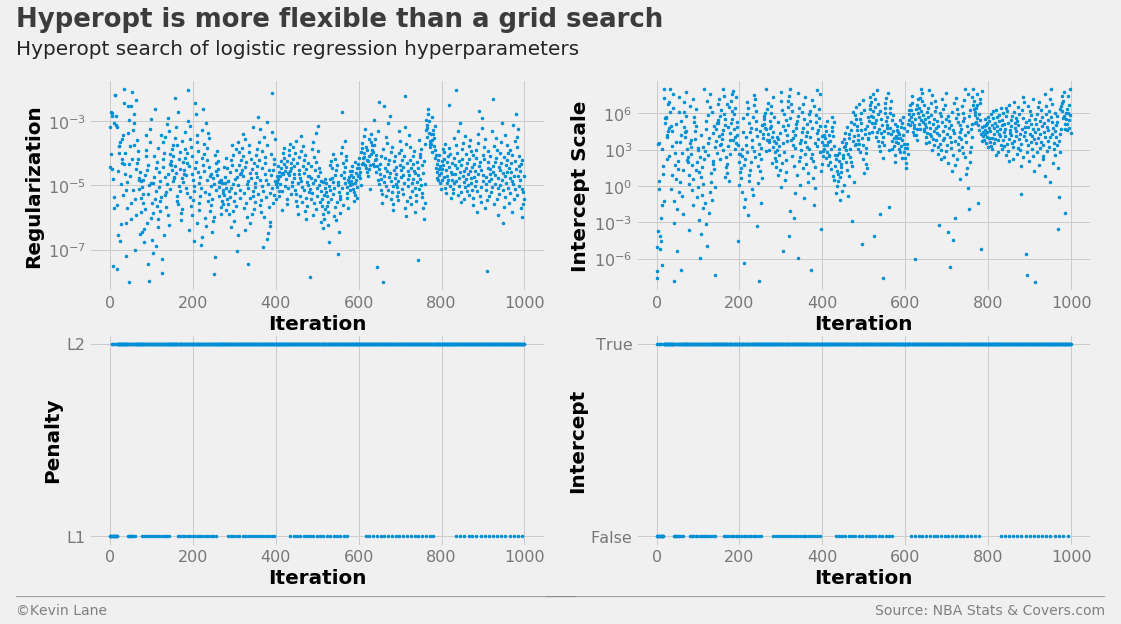

In [33]:
labels = ['Regularization', 'Intercept Scale', 'Penalty', 'Intercept']
fig, ax = plot_matrix(param_log.index.values, param_log[[k for k in space_log.keys()]].values,
                      'Iteration', labels, 2, 2, logy=[True, True, False, False])

[a.set_yticks([0, 1]) for a in ax[2:]]
ax[2].set_yticklabels(['L1', 'L2'])
ax[3].set_yticklabels(['False', 'True'])

title = 'Hyperopt is more flexible than a grid search'
subtitle = 'Hyperopt search of logistic regression hyperparameters'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle,
           xoff=(-0.18, 2.25), yoff=(-1.42, -1.52), toff=(-.16, 1.25), soff=(-0.16, 1.12),
           n=80, bottomtick=np.nan)
plt.show()

The cross-validation accuracy history shows that many models performed about the same despite their parameter values given the band of points just below 51% accuracy. The optimizer was also unable to find a model that significantly improved accuracy.

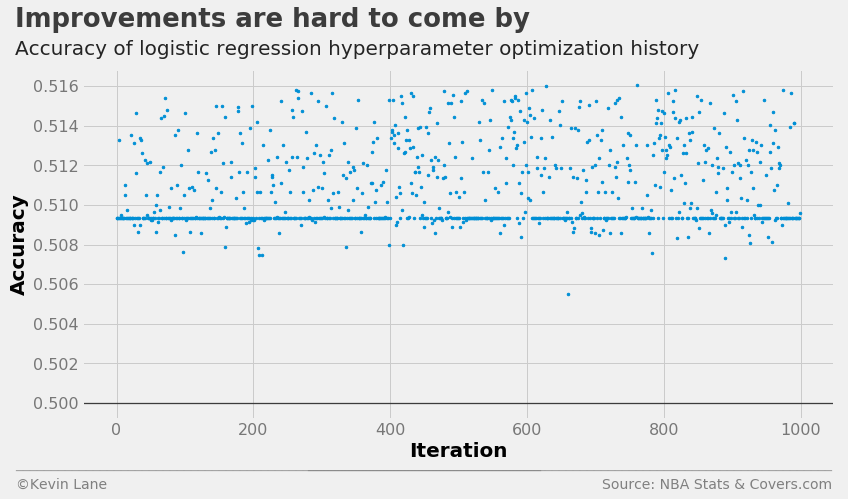

In [29]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_log.index.values, param_log['accuracy'], '.', markersize=5)

title = 'Improvements are hard to come by'
subtitle = 'Accuracy of logistic regression hyperparameter optimization history'
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.12), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

# Support Vector Machine

The [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) class is similar to a generic [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with a linear kernel, but is implemented with liblinear instead of libsvm. The documentation states that `LinearSVC` scales better to large sample sizes since `SVC`'s fit time complexity is more than quadratic with the number of samples. I initially tried `SVC`, but the training time was too costly. `LinearSVC` proved to be must faster for this application.

The code below sets up a `LinearSVC` hyperparameter search space using four parameters: `C` (penalty of the error term), `loss` (the loss function), `fit_intercept` (identical to `LogisticRegression`), and `intercept_scaling` (identical to `LogisticRegression`). I limited the number of evaluations to 500 to reduce the computational cost.

In [11]:
space_svm = {}
space_svm['C'] = hp.loguniform('C', -8*np.log(10), -2*np.log(10))
space_svm['intercept_scaling'] = hp.loguniform('intercept_scaling', -8*np.log(10), 8*np.log(10))
space_svm['loss'] = hp.choice('loss', ['hinge', 'squared_hinge'])
space_svm['fit_intercept'] = hp.choice('fit_intercept', [False, True])
model = LinearSVC()
best_svm, param_svm = optimize_params(model, x_train, y_train, stats, space_svm, max_evals=500)
print(best_svm)

{'C': 3.2563857398383885e-06, 'fit_intercept': True, 'intercept_scaling': 242.79319791592195, 'loss': 'squared_hinge'}


The search history below is similar to the logistic regression history, but hyperopt appears to test more intercept scales with low values than before. This is also indicated by the drastic reduction in the intercept scale compared to logistic regression.

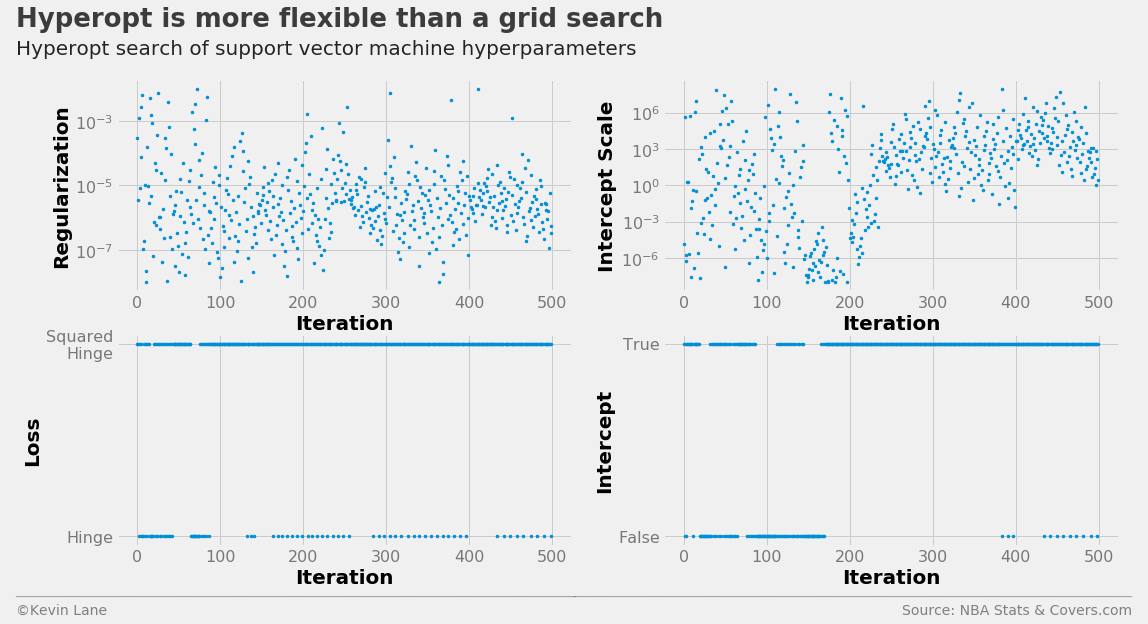

In [34]:
labels = ['Regularization', 'Intercept Scale', 'Loss', 'Intercept']
fig, ax = plot_matrix(param_svm.index.values, param_svm[[k for k in space_svm.keys()]].values,
                      'Iteration', labels, 2, 2, logy=[True, True, False, False])

[a.set_yticks([0, 1]) for a in ax[2:]]
ax[2].set_yticklabels(['Hinge', 'Squared\nHinge'])
ax[3].set_yticklabels(['False', 'True'])

title = 'Hyperopt is more flexible than a grid search'
subtitle = 'Hyperopt search of support vector machine hyperparameters'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle,
           xoff=(-0.24, 2.25), yoff=(-1.42, -1.52), toff=(-.22, 1.25), soff=(-0.22, 1.12),
           n=80, bottomtick=np.nan)
plt.show()

The plot below shows the `LinearSVC` cross-validation accuracy history. There is a band of points similar to what we observed for logistic regression below 51% accuracy. The support vector machine model does not perform much better than logistic regression, and several points fall below 50% accuracy.

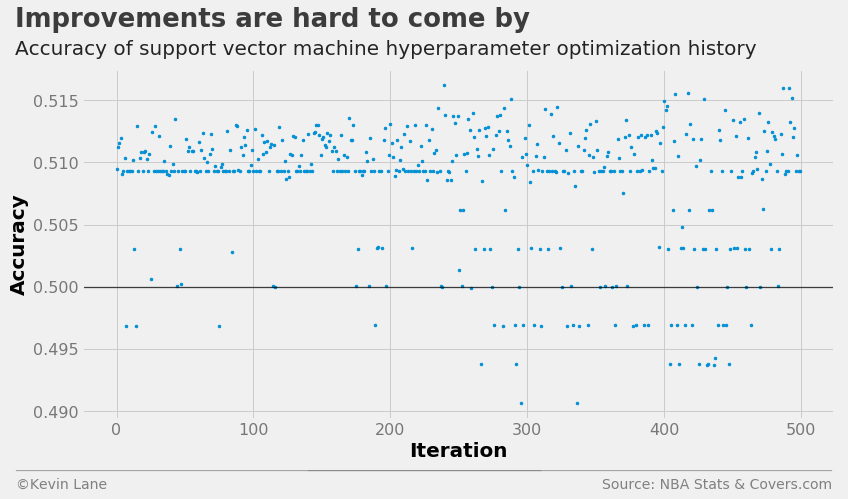

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_svm.index.values, param_svm['accuracy'], '.', markersize=5)

title = 'Improvements are hard to come by'
subtitle = 'Accuracy of support vector machine hyperparameter optimization history'
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.12), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

# Random Forest

The code below builds a [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) hyperparameter search space using the parameters `n_estimators` (number of decision trees in the forest), `class_weight` (identical to the `LogisticRegression` grid search), `criterion` (function to evaluate split quality), and `bootstrap` (controls whether bootstrap samples are used when building trees). I reduced the number of function evaluations to 100 in the interest of computational time.

In [14]:
space_rf = {}
space_rf['n_estimators'] = 10 + hp.randint('n_estimators', 40)
space_rf['criterion'] = hp.choice('criterion', ['gini', 'entropy'])
space_rf['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
space_rf['bootstrap'] = hp.choice('bootstrap', [False, True])
model = RandomForestClassifier(random_state=8)
best_rf, param_rf = optimize_params(model, x_train, y_train, stats, space_rf, max_evals=100)
print(best_rf)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 34}


The random forest hyperparameter search history is displayed below.

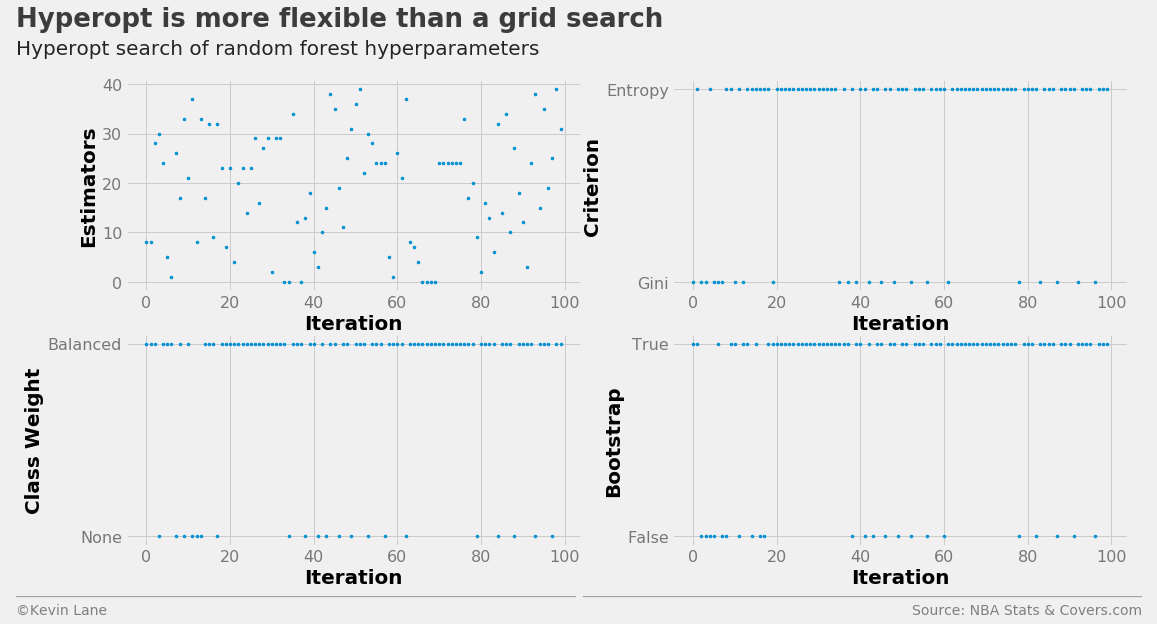

In [35]:
labels = ['Estimators', 'Criterion', 'Class Weight', 'Bootstrap']
fig, ax = plot_matrix(param_rf.index.values, param_rf[[k for k in space_rf.keys()]].values,
                      'Iteration', labels, 2, 2)

[a.set_yticks([0, 1]) for a in ax[1:]]
ax[1].set_yticklabels(['Gini', 'Entropy'])
ax[2].set_yticklabels(['None', 'Balanced'])
ax[3].set_yticklabels(['False', 'True'])

title = 'Hyperopt is more flexible than a grid search'
subtitle = 'Hyperopt search of random forest hyperparameters'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle,
           xoff=(-0.26, 2.25), yoff=(-1.42, -1.52), toff=(-.24, 1.25), soff=(-0.24, 1.12),
           n=80, bottomtick=np.nan)
plt.show()

The cross-validation accuracy history shows the random forest model performs slightly worse than logistic regression.

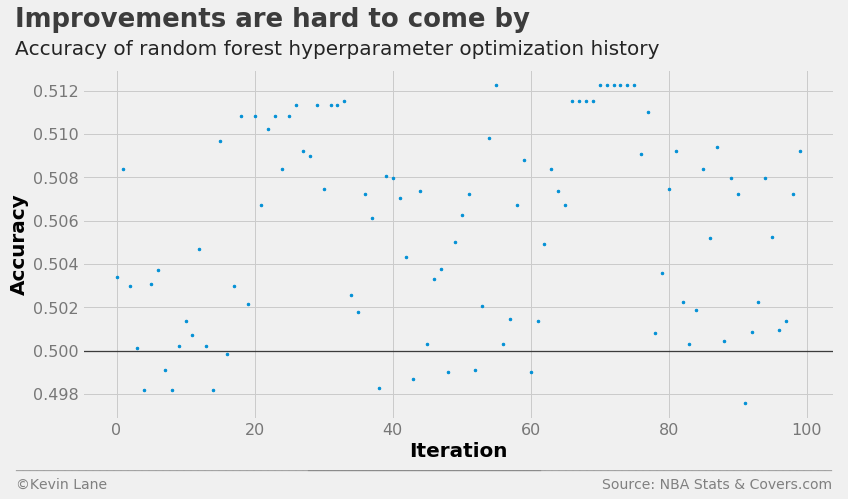

In [31]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_rf.index.values, param_rf['accuracy'], '.', markersize=5)

title = 'Improvements are hard to come by'
subtitle = 'Accuracy of random forest hyperparameter optimization history'
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.12), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

# Neural Network

The code below builds a [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) hyperparameter search space using the parameters `hidden_layer_sizes` (number of neurons in each hidden layer), `alpha` (controls the L2 regularization similar to the `C` parameter in `LogisticRegression` and `LinearSVC`), `activation` (network activation function), and `solver` (the algorithm used to optimize network weights). The network structure was held to a single hidden layer. I kept the number of function evaluations at 100 in the interest of computational time.

In [17]:
space_mlp = {}
space_mlp['hidden_layer_sizes'] = 10 + hp.randint('hidden_layer_sizes', 40)
space_mlp['alpha'] = hp.loguniform('alpha', -8*np.log(10), 3*np.log(10))
space_mlp['activation'] = hp.choice('activation', ['relu', 'logistic', 'tanh'])
space_mlp['solver'] = hp.choice('solver', ['lbfgs', 'sgd', 'adam'])
model = MLPClassifier()
best_mlp, param_mlp = optimize_params(model, x_train, y_train, stats, space_mlp, max_evals=100)
print(best_mlp)

{'activation': 'tanh', 'alpha': 5.700733605522687e-06, 'hidden_layer_sizes': 49, 'solver': 'lbfgs'}


The multi-layer perceptron hyperparameter search history is displayed below.

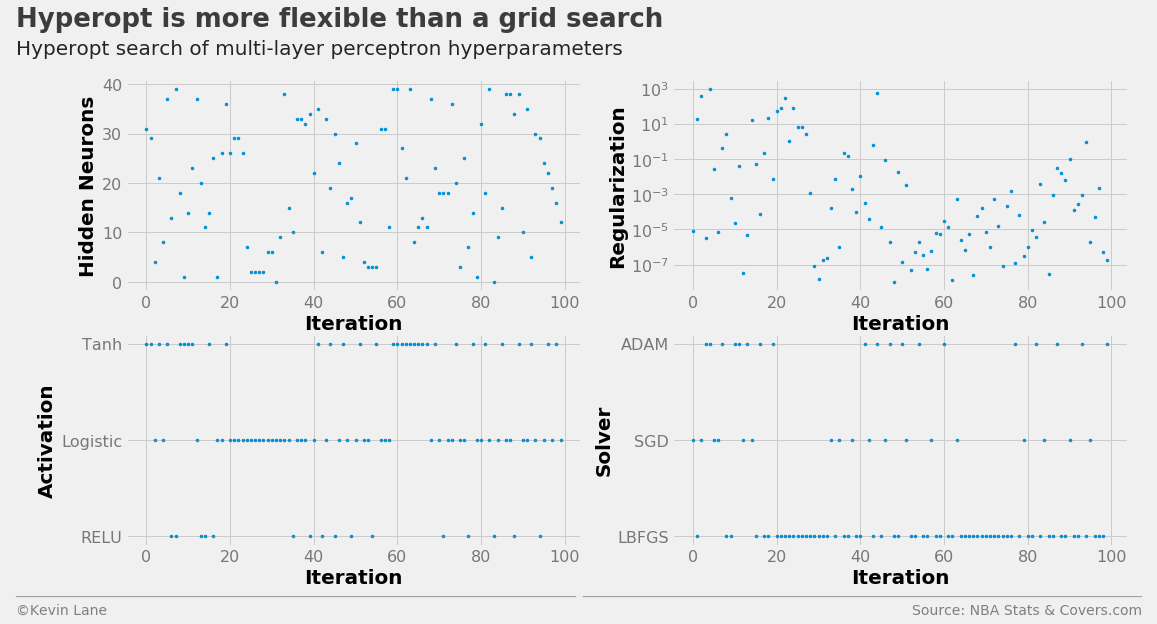

In [36]:
labels = ['Hidden Neurons', 'Regularization', 'Activation', 'Solver']
fig, ax = plot_matrix(param_mlp.index.values, param_mlp[[k for k in space_mlp.keys()]].values,
                      'Iteration', labels, 2, 2, logy=[False, True, False, False])

[a.set_yticks([0, 1, 2]) for a in ax[2:]]
ax[2].set_yticklabels(['RELU', 'Logistic', 'Tanh'])
ax[3].set_yticklabels(['LBFGS', 'SGD', 'ADAM'])

title = 'Hyperopt is more flexible than a grid search'
subtitle = 'Hyperopt search of multi-layer perceptron hyperparameters'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle,
           xoff=(-0.26, 2.25), yoff=(-1.42, -1.52), toff=(-.24, 1.25), soff=(-0.24, 1.12),
           n=80, bottomtick=np.nan)
plt.show()

The cross-validation history suggests the multi-layer perceptron performs the best of the four models, albeit the improvement is minor.

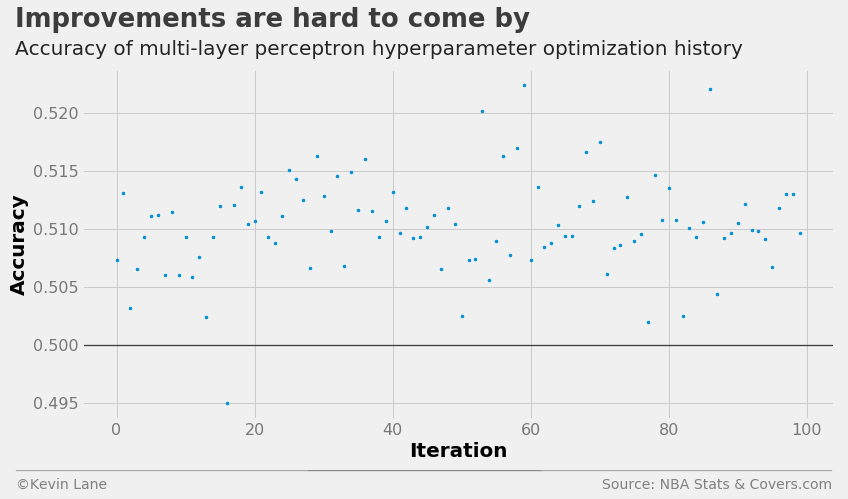

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_mlp.index.values, param_mlp['accuracy'], '.', markersize=5)

title = 'Improvements are hard to come by'
subtitle = 'Accuracy of multi-layer perceptron hyperparameter optimization history'
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.12), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()